In [95]:

import numpy as np
import random

import gym
import pybullet_envs
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Normal, MultivariateNormal

import torch.optim as optim
import time
from torch.utils.tensorboard import SummaryWriter
import argparse
import matplotlib.pyplot as plt
import tqdm


# Networks

In [96]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)


    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state):

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        mu = self.mu(x)

        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def sample(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(device)
        action = torch.tanh(e)
        log_prob = (dist.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)).sum(1, keepdim=True)

        return action, log_prob, torch.tanh(mu)
        

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, input_size, seed, hidden_size=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers
        """
        super(Critic, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        #self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state_action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    

In [97]:
class OFENet(nn.Module):
    def __init__(self, state_size, action_size, target_dim, num_layer=4, hidden_size=40):
        super(OFENet, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.target_dim = target_dim
        
        denseblock = DenseNetBlock
        state_layer = []
        action_layer = []
        
        for i in range(num_layer):
            state_layer += [denseblock(input_nodes=state_size+i*hidden_size,
                                       output_nodes=hidden_size,
                                       activation="SiLU",
                                       batch_norm=True)]
            
        self.state_layer_block = nn.Sequential(*state_layer)
        self.encode_state_out = state_size + (num_layer) * hidden_size
        action_block_input = self.encode_state_out + action_size
        
        for i in range(num_layer):
            action_layer += [denseblock(input_nodes=action_block_input+i*hidden_size,
                                       output_nodes=hidden_size,
                                       activation="SiLU",
                                       batch_norm=True)]
        self.action_layer_block = nn.Sequential(*action_layer)

        self.pred_layer = nn.Linear((state_size+(2*num_layer)*hidden_size)+action_size, target_dim)
        
    def forward(self, state, action):
        features = state
        features = self.state_layer_block(features)
        features = torch.cat((features, action), dim=1)
        features = self.action_layer_block(features)
        pred = self.pred_layer(features)

        return pred
    
    def get_state_features(self, state):
        self.state_layer_block.eval()
        with torch.no_grad():
            z0 = self.state_layer_block(state)
        self.state_layer_block.train()
        return z0
    
    def get_state_action_features(self, state, action):
        self.state_layer_block.eval()
        self.action_layer_block.eval()
        with torch.no_grad():
            z0 = self.state_layer_block(state)
            action_cat = torch.cat((z0, action), dim=1)
            z0_a = self.action_layer_block(action_cat)
        self.state_layer_block.train()
        self.action_layer_block.train()
        return z0_a
    
    def train_ofenet(self, experiences, optim):
        states, actions, rewards, next_states, dones = experiences
        # ---------------------------- update OFENet ---------------------------- #
        pred = self.forward(states, actions)
        target_states = next_states[:, :self.target_dim]
        ofenet_loss = (target_states - pred).pow(2).mean()
        

        optim.zero_grad()
        ofenet_loss.backward()
        optim.step()
        return ofenet_loss.item()
    
    def get_action_state_dim(self,):
        return (self.state_size+(2*self.num_layer)*self.hidden_size)+self.action_size
    
    def get_state_dim(self,):
        return self.encode_state_out

In [98]:
class DenseNetBlock(nn.Module):
    def __init__(self, input_nodes, output_nodes, activation, batch_norm=False):
        super(DenseNetBlock, self).__init__()
        
        
        self.do_batch_norm = batch_norm
        if batch_norm:
            self.layer = nn.Linear(input_nodes, output_nodes, bias=True)
            nn.init.xavier_uniform_(self.layer.weight)
            nn.init.zeros_(self.layer.bias)
            self.batch_norm = nn.BatchNorm1d(output_nodes) #, momentum=0.99, eps=0.001
        else:
            self.layer = nn.Linear(input_nodes, output_nodes)
        if activation == "SiLU":
            self.act = nn.SiLU()
        elif activation == "ReLU":
            self.act = nn.ReLU()
        else:
            print("Activation Function can not be selected!")
        
    def forward(self, x):
        identity_map = x
        features = self.layer(x)

        if self.do_batch_norm:
            features = self.batch_norm(features)
        features = self.act(features)
        assert features.shape[0] == identity_map.shape[0], "features: {} | identity: {}".format(features.shape, identity_map.shape)
        features = torch.cat((features, identity_map), dim=1)
        return features

In [99]:
def train(steps, precollected, print_every=10):
    scores_deque = deque(maxlen=100)
    average_100_scores = []
    scores = []
    losses = []

    state = env.reset()
    state = state.reshape((1, state_size))
    score = 0
    i_episode = 1
    for step in range(precollected+1, steps+1):

        action = agent.act(state)
        action_v = action.numpy()
        action_v = np.clip(action_v, action_low, action_high)
        next_state, reward, done, info = env.step(action_v)
        next_state = next_state.reshape((1, state_size))
        ofenet_loss, a_loss, c_loss = agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            scores_deque.append(score)
            scores.append(score)
            average_100_scores.append(np.mean(scores_deque))
            losses.append((ofenet_loss, a_loss, c_loss))
            print('\rEpisode {} Frame: [{}/{}] Reward: {:.2f}  Average100 Score: {:.2f} ofenet_loss: {:.3f}, a_loss: {:.3f}, c_loss: {:.3f}'.format(i_episode, step, steps, score, np.mean(scores_deque), ofenet_loss, a_loss, c_loss))
            state = env.reset()
            state = state.reshape((1, state_size))
            score = 0
            i_episode += 1
             

    return scores

In [100]:
agent.ofenet.state_layer_block[0].layer

Linear(in_features=26, out_features=30, bias=True)

In [101]:
def fill_buffer(samples=1000):
    collected_samples = 0
    
    state = env.reset()
    state = state.reshape((1, state_size))
    for i in range(samples):
            
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        next_state = next_state.reshape((1, state_size))
        agent.memory.add(state, action, reward, next_state, done)
        collected_samples += 1
        state = next_state
        if done:
            state = env.reset()
            state = state.reshape((1, state_size))
    print("Adding random samples to buffer done! Buffer size: ", agent.memory.__len__())
                
def pretrain_ofenet(agent, epochs):
    losses = []

    for ep in range(epochs):
        states, actions, rewards, next_states, dones = agent.memory.sample()
        # ---------------------------- update OFENet ---------------------------- #
        pred = agent.ofenet.forward(states, actions)
        targets = next_states[:,:17]
        ofenet_loss = (targets-pred).pow(2).mean()
        agent.ofenet_optim.zero_grad()
        ofenet_loss.backward()
        agent.ofenet_optim.step()
        losses.append(ofenet_loss.item())
    plt.plot(losses)
    plt.show()
    print(losses[-1])
    return agent

# Train SAC

# Train OFENet REDQ

In [102]:
class REDQ_Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, device, action_prior="uniform", N=2, M=2, G=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.hidden_size = 256
        
        self.target_entropy = -action_size  # -dim(A)
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=lr) 
        self._action_prior = action_prior
        self.alphas = []
        print("Using: ", device)
        
        # REDQ parameter
        self.N = N # number of critics in the ensemble
        self.M = M # number of target critics that are randomly selected
        self.G = G # Updates per step ~ UTD-ratio
        
        ofenet_size = 30
        self.ofenet = OFENet(state_size, action_size, target_dim=17, num_layer=8, hidden_size=ofenet_size).to(device)
        # TODO: CHECK ADAM PARAMS WITH TF AND PAPER
        self.ofenet_optim = optim.Adam(self.ofenet.parameters(), lr=3e-4, eps=1e-07)  
        print(self.ofenet)

        # split state and action ~ weird step but to keep critic inputs consistent
        feature_size = self.ofenet.get_state_dim()
        feature_action_size = self.ofenet.get_action_state_dim()
        
        # Actor Network 
        self.actor_local = Actor(feature_size, action_size, random_seed, hidden_size=self.hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr)     
        
        # Critic Network (w/ Target Network)
        self.critics = []
        self.target_critics = []
        self.optims = []
        for i in range(self.N):
            critic = Critic(feature_action_size, i, hidden_size=self.hidden_size).to(device)

            optimizer = optim.Adam(critic.parameters(), lr=lr, weight_decay=0)
            self.optims.append(optimizer)
            self.critics.append(critic)
            target = Critic(feature_action_size, i, hidden_size=self.hidden_size).to(device)
            self.target_critics.append(target)


        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
        

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        actor_loss, critic1_loss, ofenet_loss = 0, 0, 0
        for update in range(self.G):
            if len(self.memory) > batch_size:
                ofenet_loss = self.ofenet.train_ofenet(self.memory.sample(), self.ofenet_optim)
                experiences = self.memory.sample()
                actor_loss, critic1_loss = self.learn(update, experiences, gamma)
        return ofenet_loss, actor_loss, critic1_loss # future ofenet_loss
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        self.ofenet.eval()
        with torch.no_grad():
            state = self.ofenet.get_state_features(state)
            action, _, _ = self.actor_local.sample(state)
        self.actor_local.train()
        self.ofenet.train()
        return action.detach().cpu()[0]
    
    def eval_(self, state):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        self.ofenet.eval()
        with torch.no_grad():
            state = self.ofenet.get_state_features(state)
            _, _ , action = self.actor_local.sample(state)
        self.actor_local.train()
        self.ofenet.train()
        return action.detach().cpu()[0]
    
    def learn(self, step, experiences, gamma):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # sample target critics
        idx = np.random.choice(len(self.critics), self.M, replace=False) # replace=False so that not picking the same idx twice
        

        # ---------------------------- update critic ---------------------------- #

        with torch.no_grad():
            # Get predicted next-state actions and Q values from target models
            next_state_features = self.ofenet.get_state_features(next_states)
            next_action, next_log_prob, _ = self.actor_local.sample(next_state_features)
            next_state_action_features = self.ofenet.get_state_action_features(next_states, next_action) #get_state_action_features
            # TODO: make this variable for possible more than tnext_state_action_featureswo target critics
            Q_target1_next = self.target_critics[idx[0]](next_state_action_features)
            Q_target2_next = self.target_critics[idx[1]](next_state_action_features)
            
            # take the min of both critics for updating
            Q_target_next = torch.min(Q_target1_next, Q_target2_next) - self.alpha.to(device) * next_log_prob

        Q_targets = 5.0*rewards.cpu() + (gamma * (1 - dones.cpu()) * Q_target_next.cpu())

        # Compute critic losses and update critics 
        state_action_features = self.ofenet.get_state_action_features(states, actions)
        for critic, optim, target in zip(self.critics, self.optims, self.target_critics):
            Q = critic(state_action_features).cpu()
            Q_loss = 0.5*F.mse_loss(Q, Q_targets)
        
            # Update critic
            optim.zero_grad()
            Q_loss.backward()
            optim.step()
            # soft update of the targets
            self.soft_update(critic, target)
        
        # ---------------------------- update actor ---------------------------- #
        if step == self.G-1:
            state_features = self.ofenet.get_state_features(states)
            actions_pred, log_prob, _ = self.actor_local.sample(state_features)             
            
            state_action_features = self.ofenet.get_state_action_features(states, actions_pred)
            # TODO: make this variable for possible more than two critics
            Q1 = self.critics[idx[0]](state_action_features).cpu()
            Q2 = self.critics[idx[0]](state_action_features).cpu()
            Q = torch.min(Q1,Q2)
            actor_loss = (self.alpha * log_prob.cpu() - Q).mean()
            # Optimize the actor loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Compute alpha loss 
            alpha_loss = - (self.log_alpha.exp() * (log_prob.cpu() + self.target_entropy).detach().cpu()).mean()

            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp().detach()
            self.alphas.append(self.alpha.detach())
            
        return actor_loss.item(), Q_loss.item()

    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [103]:

env_name = "HalfCheetahBulletEnv-v0" #"HalfCheetahPyBulletEnv-v0"#"Pendulum-v0"
max_steps = 1_000_000
seed = 1
#Hyperparameter
lr = 3e-4
buffer_size = int(1e6)
batch_size = 256
tau = 0.005
gamma = 0.99

random_collect = 10000

# RED-Q Parameter
N = 2
M = 2
G = 1

#writer = SummaryWriter("runs/"+args.info)
env = gym.make(env_name)
action_high = env.action_space.high[0]
action_low = env.action_space.low[0]
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = REDQ_Agent(state_size=state_size,
              action_size=action_size,
              random_seed=seed,
              device=device,
              action_prior="uniform", N=N, M=M, G=G)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable OFENet Parameter: ", count_parameters(agent.ofenet))

Using:  cpu
OFENet(
  (state_layer_block): Sequential(
    (0): DenseNetBlock(
      (layer): Linear(in_features=26, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (1): DenseNetBlock(
      (layer): Linear(in_features=56, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (2): DenseNetBlock(
      (layer): Linear(in_features=86, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (3): DenseNetBlock(
      (layer): Linear(in_features=116, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (4): DenseNetBlock(
      (layer): Linear(in_features=146, out_features=30, 

Adding random samples to buffer done! Buffer size:  10000


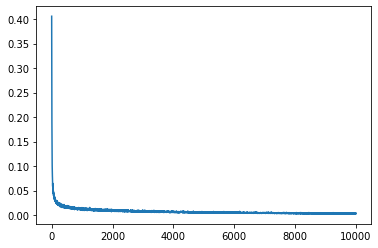

0.00331158097833395


In [104]:
import time
fill_buffer(samples=random_collect)
start_time = time.time()
agent = pretrain_ofenet(agent, epochs=random_collect)
end_time = time.time()


In [77]:
print("pre-training took: {}".format((end_time-start_time)/60))

pre-training took: 3.44853032430013


# paper achieves loss of ~ 0.005

In [105]:
torch.save(agent.ofenet.state_dict(), "ofenet_params_cheetah.pth")

In [106]:
agent.ofenet.load_state_dict(torch.load("ofenet_params_cheetah.pth"))
agent.ofenet.to(device)

OFENet(
  (state_layer_block): Sequential(
    (0): DenseNetBlock(
      (layer): Linear(in_features=26, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (1): DenseNetBlock(
      (layer): Linear(in_features=56, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (2): DenseNetBlock(
      (layer): Linear(in_features=86, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (3): DenseNetBlock(
      (layer): Linear(in_features=116, out_features=30, bias=True)
      (batch_norm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (4): DenseNetBlock(
      (layer): Linear(in_features=146, out_features=30, bias=True)
 

In [107]:
t0 = time.time()
scores = train(max_steps, random_collect)
t1 = time.time()
env.close()
print("training took {} min!".format((t1-t0)/60))

Episode 1 Frame: [11000/1000000] Reward: -1095.94  Average100 Score: -1095.94 ofenet_loss: 0.003, a_loss: 12.023, c_loss: 9.186
Episode 2 Frame: [12000/1000000] Reward: -1154.81  Average100 Score: -1125.38 ofenet_loss: 0.003, a_loss: 30.677, c_loss: 14.340
Episode 3 Frame: [13000/1000000] Reward: -1317.20  Average100 Score: -1189.32 ofenet_loss: 0.003, a_loss: 52.550, c_loss: 18.166
Episode 4 Frame: [14000/1000000] Reward: -1231.73  Average100 Score: -1199.92 ofenet_loss: 0.004, a_loss: 79.028, c_loss: 19.346
Episode 5 Frame: [15000/1000000] Reward: -1371.70  Average100 Score: -1234.28 ofenet_loss: 0.003, a_loss: 107.285, c_loss: 26.071
Episode 6 Frame: [16000/1000000] Reward: -1027.28  Average100 Score: -1199.78 ofenet_loss: 0.004, a_loss: 130.426, c_loss: 19.074
Episode 7 Frame: [17000/1000000] Reward: -1238.18  Average100 Score: -1205.26 ofenet_loss: 0.004, a_loss: 156.055, c_loss: 23.853


KeyboardInterrupt: 

# Actor loss is the problem!!